#  Wildfire analysis using Sentinel 2 Imagery

> * 🔬 Data Science
* 🖥️ Requires RasterAnalytics Portal Configuration
* 🖥️ Requires GeoEnrichment Portal Configuration
* 🖥️ Requires GeoAnalytics Portal Configuration

The Pawnee Fire was a large wildfire that burned in Lake County, California. The fire started on June 23, 2018 and burned a total of 15,185 acres (61 km2) before it was fully contained on July 8, 2018.

In this sample, we will delineate the burn extent from the satellite imagery and perform a quantitative assessment of the burn areas. Finally, we will perform an impact assessment by enriching the affected area with demographic data and understand the population that is affected.


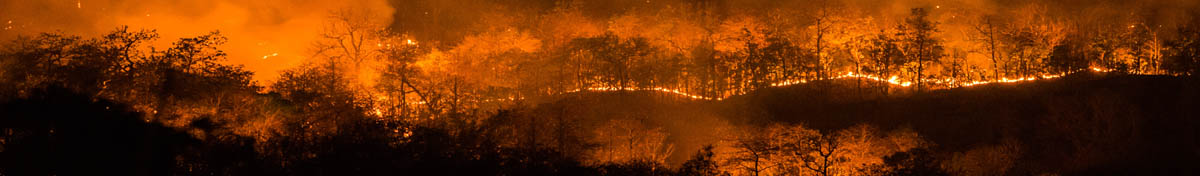

<h1>**Table of Contents** <span class="tocSkip"></span> </h1> <div class="toc"> <ul class="toc-item"> <li> <span> <a href="#Wildfire-analysis-using-Sentinel-2-Imagery" data-toc-modified-id="Wildfire-analysis-using-Sentinel-2-Imagery-1">Wildfire analysis using Sentinel 2 Imagery</a> </span> <ul class="toc-item"> <li> <span> <a href="#Remote-Sensing-using-Sentinel-2-layer" data-toc-modified-id="Remote-Sensing-using-Sentinel-2-layer-1.1">Remote Sensing using Sentinel-2 layer</a> </span> <ul class="toc-item"> <li> <span> <a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.2">Data Preparation</a> </span> <li> <span> <a href="#Select-prefire-and-midfire-scenes-from-the-image-collection" data-toc-modified-id="Select-prefire-and-midfire-scenes-from-the-image-collection-1.2">Select prefire and midfire scenes from the image collection</a> </span> </li> <li> <span> <a href="#Visual-Assessment" data-toc-modified-id="Visual-Assessment-1.3">Visual Assessment</a> </span> <ul class="toc-item"> <li> <span> <a href="#Visualize-Burn-Scars" data-toc-modified-id="Visualize-Burn-Scars-1.2.1">Visualize Burn Scars</a> </span> </li> </ul> </li> <li> <span> <a href="#Quantitative-Assessment" data-toc-modified-id="Quantitative-Assessment-1.4">Quantitative Assessment</a> </span> <ul class="toc-item"> <li> <span> <a href="#Use-Band-Arithmetic-and-Map-Algebra" data-toc-modified-id="Use-Band-Arithmetic-and-Map-Algebra-1.3.1">Use Band Arithmetic and Map Algebra</a> </span> </li> <li> <span> <a href="#Area-calculation" data-toc-modified-id="Area-calculation-1.3.2">Area calculation</a> </span> </li> <li> <span> <a href="#Report-burnt-area" data-toc-modified-id="Report-burnt-area-1.3.3">Report burnt area</a> </span> </li> <li> <span> <a href="#Visualize-burnt-areas" data-toc-modified-id="Visualize-burnt-areas-1.3.4">Visualize burnt areas</a> </span> </li> <li> <span> <a href="#Persist-the-burnt-areas-layer-in-the-GIS" data-toc-modified-id="Persist-the-burnt-areas-layer-in-the-GIS-1.3.5">Persist the burnt areas layer in the GIS</a> </span> </li> </ul> </li> <li> <span> <a href="#Raster-to-Feature-layer-conversion" data-toc-modified-id="Raster-to-Feature-layer-conversion-1.4">Raster to Feature layer conversion</a> </span> </li> <li> <span> <a href="#Visualize-Feature-Layer" data-toc-modified-id="Visualize-Feature-Layer-1.5">Visualize Feature Layer</a> </span> </li> <li> <span> <a href="#Impact-Assessment" data-toc-modified-id="Impact-Assessment-1.6">Impact Assessment</a> </span> <ul class="toc-item"> <li> <span> <a href="#Assess-Human-Impact" data-toc-modified-id="Assess-Human-Impact-1.6.1">Assess Human Impact</a> </span> </li> <li> <span> <a href="#Demographics-of-people-affected-by-the-fire-based-on-age-and-gender" data-toc-modified-id="Demographics-of-people-affected-by-the-fire-based-on-age-and-gender-1.6.2">Demographics of people affected by the fire based on age and gender</a> </span> </li> </ul> </li> </ul> </li> <li> <span> <a href="#Conclusion" data-toc-modified-id="Conclusion-2">Conclusion</a> </span> </li> <li> <span> <a href="#Data-Credits" data-toc-modified-id="Data-Credits-3">Data Credits</a> </span> </li> </ul> </li> </ul> </div>

## Remote Sensing using Sentinel-2 layer

In [1]:
from datetime import datetime
import warnings

from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arcgis
from arcgis import GIS
from arcgis.raster.functions import *
from arcgis.geoanalytics.use_proximity import create_buffers
from arcgis.geoenrichment import enrich
from arcgis.features import SpatialDataFrame
from arcgis.raster.analytics import create_image_collection
from arcgis.raster.analytics import list_datastore_content

gis= GIS("home")

### Data Preparation

In this workflow, we first download the data from https://earthexplorer.usgs.gov/ by following these steps:
- Login to your account
-  Define Your Study Area
 - In 'Enter Search Criteria' click on Adress/Place, enter Lake County, California and click Show.
 - Select the Address/Place that pops up on clicking the Show option in the previous step. This will add the coordinated to the Area of interest control.
 - In 'Date Range', set 06/22/2018 and 06/28/2018 in 'Search from' and 'to' respectively
-  Define the Data That You Want to Download
 - Next click on the Data sets tab. Click Sentinel and expand the drop down to find Sentinel-2.
- Define Selection Criteria

 - Next select the Additional Criteria tab.
 - Start with Less than 20% cloud cover and see what you get as data results.
- View Results & Select Data Download
 - Finally click on the Results tab, to see all of the scenes that cover your study area.
 - Select download option for the scenes that are closest to pre fire and mid fire dates and with least amount of cloud cover

To directly download the data to /arcgis/home folder, you may use !wget. For this you can use CurlWget extension to get the url to be used for downloading the data. 

Once the sentinel-2 data is downloaded, following steps are to be performed:
 -  Move/copy the data to a folder (here sentinel_data_pawnee) in rasterstore of the raster analysis server.
 -  Optionally, list the contents of the folder.
 -  Create an image collection out of the data in sentinel_data_pawnee folder.



In [128]:
list_datastore_content("/rasterStores/LocalRasterStore/sentinel_data_pawnee")

['/rasterStores/LocalRasterStore/sentinel_data_pawnee/L1C_T10SEJ_A006760_20180622T190432/',
 '/rasterStores/LocalRasterStore/sentinel_data_pawnee/L1C_T10SEJ_A015697_20180624T190108/']

In [129]:
sentinel_collection = create_image_collection(image_collection="pawnee_fire_analysis_collection",
                      input_rasters=["/rasterStores/LocalRasterStore/sentinel_data_pawnee"],
                      raster_type_name="Sentinel-2", 
                      raster_type_params={"productType":"All","processingTemplate":"Multispectral"},
                      context={"image_collection_properties":{"imageCollectionType":"Satellite"},"byref":True}, 
                      gis = gis)

In [3]:
sentinel = sentinel_collection.layers[0]

### Select prefire and midfire scenes from the image collection

Here we select a pre-fire and mid-fire satellite scenes. We define an area of interest and start off by first running a preliminary search for all applicable scenes between two approximate dates.

In [4]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmax': -13643017.100720055,
 'xmin': -13652113.10708598,
 'ymax': 4739654.477447927,
 'ymin': 4731284.622850712}
arcgis.env.analysis_extent = aoi
sentinel.extent = aoi

The following step is optional and will be useful in collections that have more number of scenes, to limit your search results to a particular date range and area of interest. 

In [4]:
selected = sentinel.filter_by(where="acquisitiondate BETWEEN timestamp '2018-06-15 00:00:00' AND timestamp '2018-06-24 19:59:59'",
                              geometry=arcgis.geometry.filters.intersects(aoi))

In [16]:
df = selected.query(out_fields="*").df
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df[['AcquisitionDate','OBJECTID','ProductName', 'GroupName', 'CloudCover']]

,AcquisitionDate,OBJECTID,ProductName,GroupName,CloudCover
0,2018-06-22 18:59:19.024,1,S2MSI1C,MTD_MSIL1C,0
1,2018-06-24 18:49:21.024,2,S2MSI1C,MTD_MSIL1C,0


We pick two scenes that best represent the pre and mid incident ground condition.

In [6]:
prefire = sentinel.filter_by('OBJECTID=1') 
midfire = sentinel.filter_by('OBJECTID=2')

## Visual Assessment

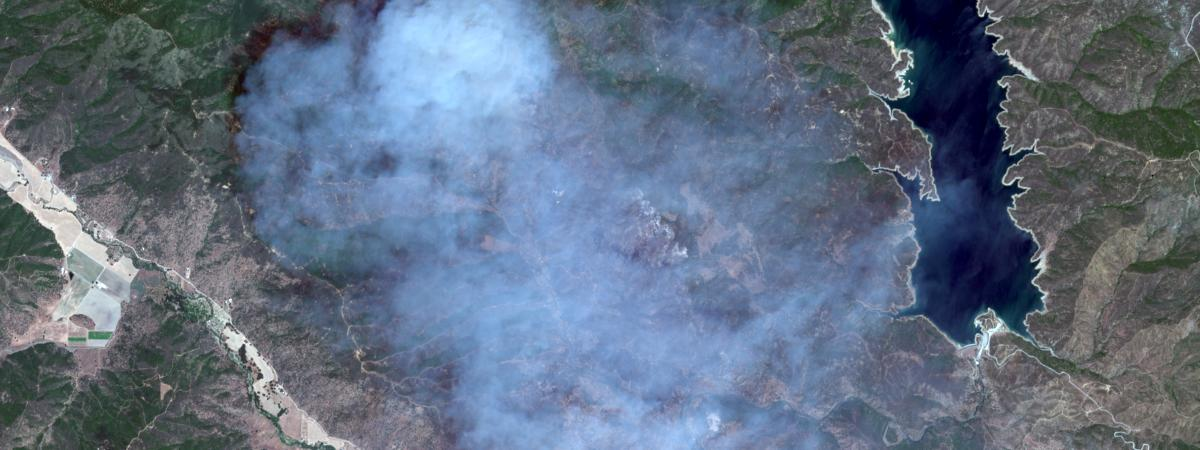

In [7]:
truecolor = extract_band(midfire, [4,3,2])
truecolor

### Visualize Burn Scars

Extract the bands - [13, 12, 4] from the mid fire layer to improve visibility of fire and burn scars. This band combination pushes further into the SWIR range of the electromagnetic spectrum, where there is less susceptibility to smoke and haze generated by a burning fire.

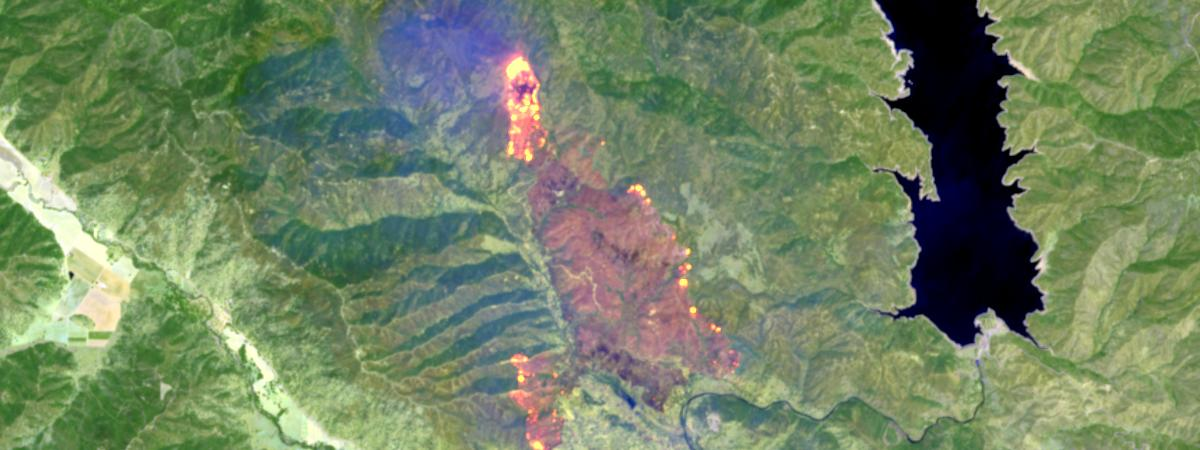

In [8]:
extract_band(midfire, [13,12,4])

For comparison, the same area before the fire started shows no burn scar.

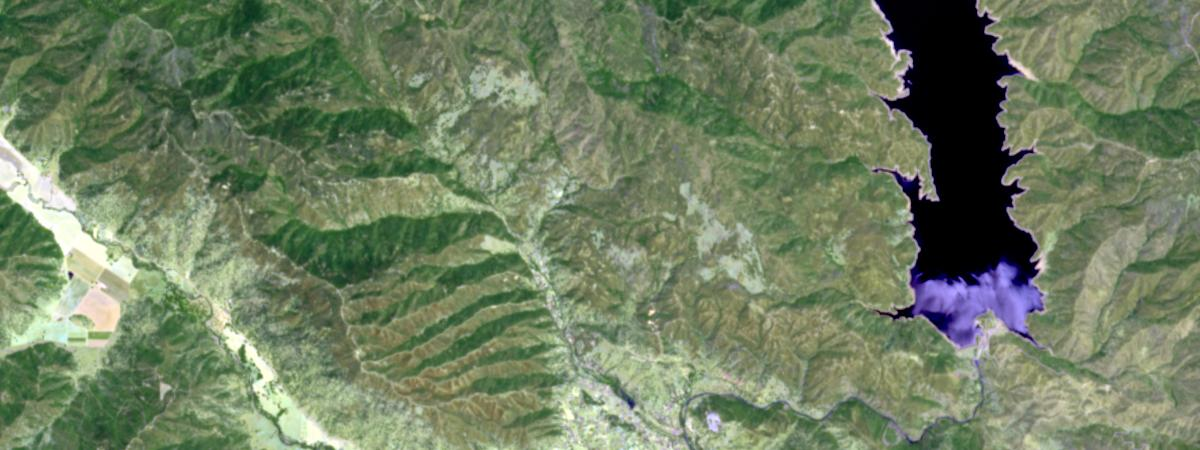

In [9]:
extract_band(prefire, [13,12,4])


## Quantitative Assessment

The **Normalized Burn Ratio (NBR)** can be used to delineate the burnt areas and identify the severity of the fire. 

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 9 and the short-wave infrared band 13:
\begin{align}
{\mathbf{NBR}} = \frac{\mathbf{B9} - \mathbf{B13}}{\mathbf{B9} + \mathbf{B13} + \mathbf{WS}} \\   
\end{align}

The NBR equation was designed to be calcualted from reflectance, but it can be calculated from radiance and digital_number_(dn) with changes to the burn severity table below. The WS parameter is used for water suppression, and is typically 2000. 

For a given area, NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is judged by taking the difference between these two index layers:

\begin{align}
{\Delta \mathbf{NBR}} = \mathbf{NBR_{prefire}} - \mathbf{NBR_{postfire}} \\   
\end{align}

The meaning of the ∆NBR values can vary by scene, and for best results interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:


| \begin{align}{\Delta \mathbf{NBR}}  \end{align}      | Burn Severity |
| ------------- |:-------------:|
| 0.1 to 0.27   | Low severity burn |
| 0.27 to 0.44  | Medium severity burn |
| 0.44 to 0.66 | Moderate severity burn |
| > 0.66 | High severity burn |

[ Source: http://gsp.humboldt.edu/olm_2015/Courses/GSP_216_Online/lesson5-1/NBR.html ]

### Use Band Arithmetic and Map Algebra 

In [10]:
nbr_prefire  = band_arithmetic(prefire, "(b9 - b13) / (b9 + b13 + 2000)")
nbr_postfire = band_arithmetic(midfire, "(b9 - b13) / (b9 + b13 + 2000)")

nbr_diff = nbr_prefire - nbr_postfire

In [11]:
burnt_areas = colormap(remap(nbr_diff, 
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'), 
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0,    0]])

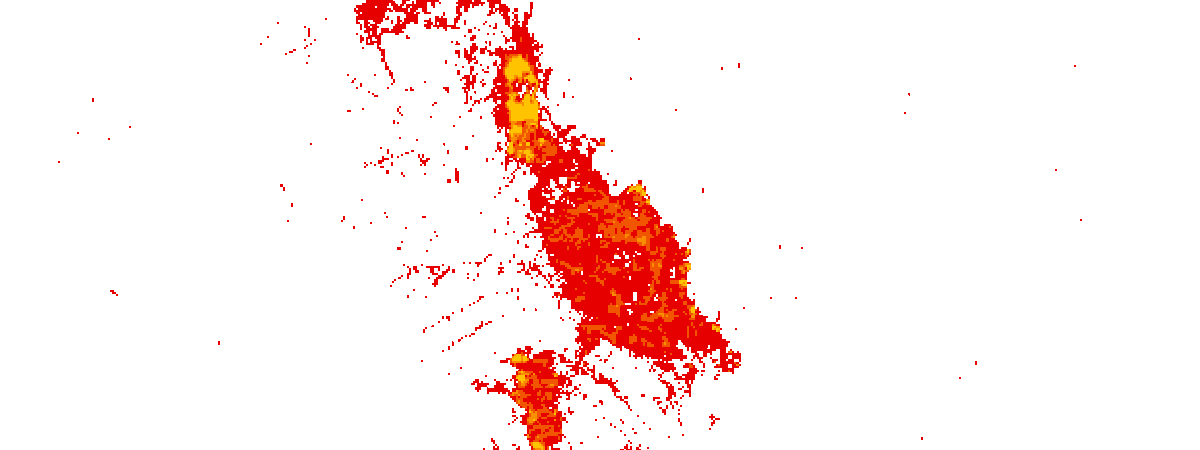

In [12]:
# Visualize burnt areas
burnt_areas

With this, we have computed the NBR on scenes from before and during the burn, and computed the NBR difference to identify places that have been affected by the fire. We've also normalized the values to match a burn severity index, and applied a color map that brings out the extent of the damage caused by the fire.

### Area calculation

In [13]:
pixx = (aoi['xmax'] - aoi['xmin']) / 1200.0
pixy = (aoi['ymax'] - aoi['ymin']) / 450.0

res = burnt_areas.compute_histograms(aoi, pixel_size={'x':pixx, 'y':pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

### Report burnt area

In [14]:
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

HTML('<h3>Fire has consumed <font color="red">{:,} acres</font>  till {}</h3>.' \
     .format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

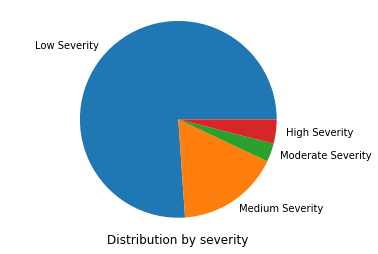

In [15]:
%matplotlib inline

plt.title('Distribution by severity', y=-0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 'Moderate Severity', 'High Severity']);
plt.axis('equal');

### Visualize burnt areas


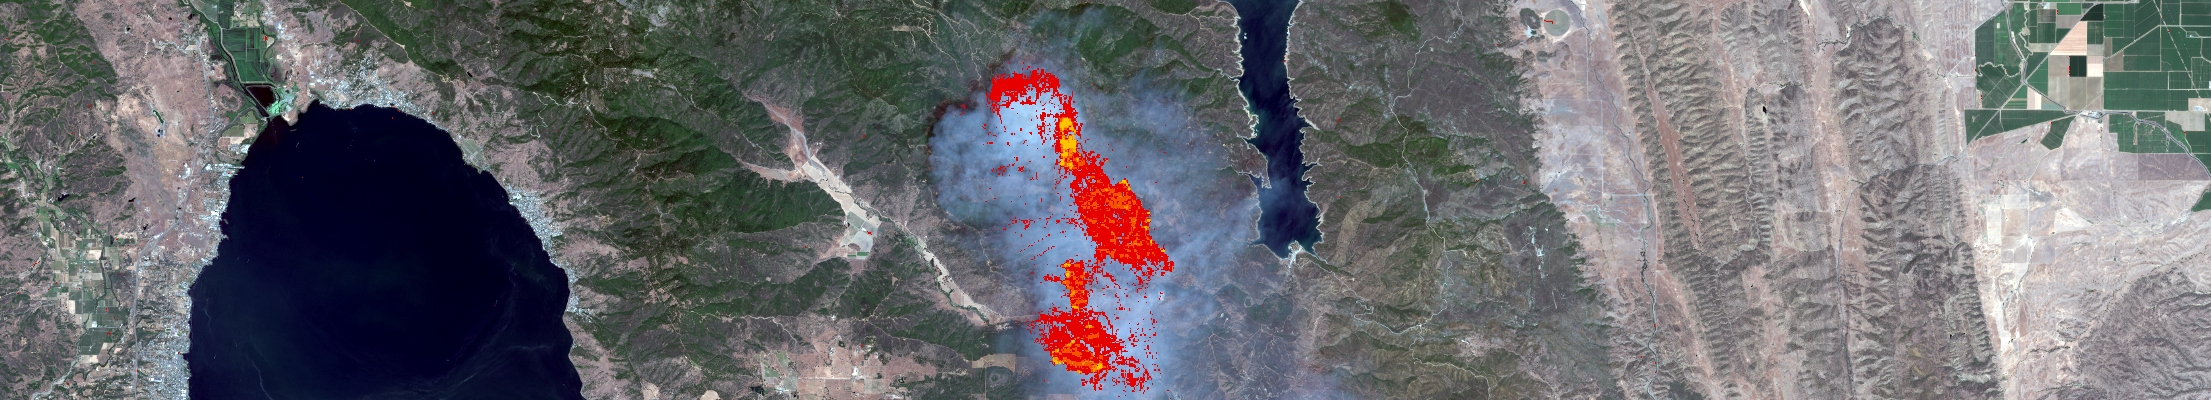

In [34]:
firemap = gis.map()
firemap.extent = aoi
firemap.add_layer([truecolor,burnt_areas])

firemap


### Persist the burnt areas layer in the GIS

If required, using the save(), we can persist the output in the gis as a new layer. This uses distributed raster analysis to perform the analysis at the source resolution.

In [23]:
burnt_areas = burnt_areas.save()

## Raster to Feature layer conversion

Use Raster Analytics and Geoanalytics to convert the burnt area raster to a feature layer. The `to_features()` method converts the raster to a feature layer and `create_buffers()` fills holes in the features and dissolves them to output one feature that covers the extent of the Pawnee Fire.

In [27]:
burnt_areas = burnt_areas.layers[0]
fire_item = burnt_areas.to_features(output_name='Pawnee_Fire_Feature_Layer', gis=gis)
fire_layer = fire_item.layers[0]


In [3]:
fire = create_buffers(fire_layer, 100, 'Meters', dissolve_option='All', multipart=True, output_name='PawneeFireArea')
fire = fire.layers[0]

<Item title:"PawneeFireArea" type:Feature Layer Collection owner:rjackson>
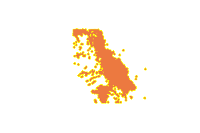

In [53]:
fire = gis.content.search("title: PawneeFireArea")[0]
fire

## Visualize Feature Layer


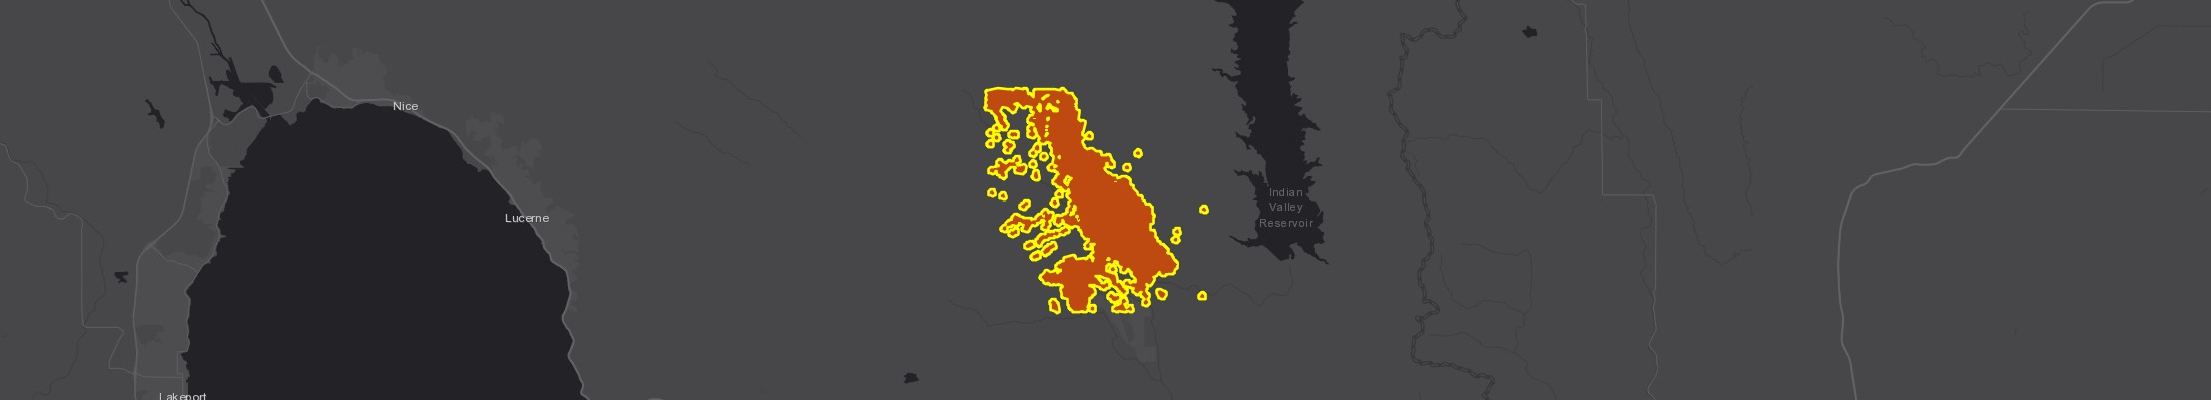

In [32]:
vectormap = gis.map()
vectormap.basemap = 'dark-gray'
vectormap.extent  = aoi

vectormap.add_layer(fire)
vectormap

## Impact Assessment

### Assess Human Impact

In [19]:
from arcgis import geometry 
 
sdf = SpatialDataFrame.from_layer(fire)

fire_geometry = sdf.iloc[0].SHAPE
sa_filter = geometry.filters.intersects(geometry=fire_geometry, sr=4326)

def age_gender_pyramid(df):
    %matplotlib inline
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.options.mode.chained_assignment = None 
    plt.style.use('ggplot')
    df = df[[x for x in impacted_people.columns if 'MALE' in x or 'FEM' in x]]
    sf = pd.DataFrame(df.sum())
    age = sf.index.str.extract('(\d+)').astype('int64')
    f = sf[sf.index.str.startswith('FEM')]
    m = sf[sf.index.str.startswith('MALE')]
    sf = sf.reset_index(drop = True)
    f = f.reset_index(drop = True)
    m = m.reset_index(drop = True)
    sf['age'] = age
    f["age"] = age
    m["age"] = age
    f = f.sort_values(by='age', ascending=False).set_index('age')
    m = m.sort_values(by='age', ascending=False).set_index('age')
    

    popdf = pd.concat([f, m], axis=1)
    popdf.columns = ['F', 'M']
    popdf['agelabel'] = popdf.index.map(str) + ' - ' + (popdf.index+4).map(str)
    popdf.M = -popdf.M
    fig, axes = plt.subplots(ncols=2, sharey=True)
    sns.barplot(x="F", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none', ax=axes[1])
    sns.barplot(x="M",  y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none', ax=axes[0])
    axes[1].set_title("Female")
    axes[0].set_title("Male")
    axes[1].set(xlabel="Number of people", ylabel="") 
    axes[0].set(xlabel="Number of people", ylabel="Age Group") 
    return plt;

### Demographics of people affected by the fire based on age and gender

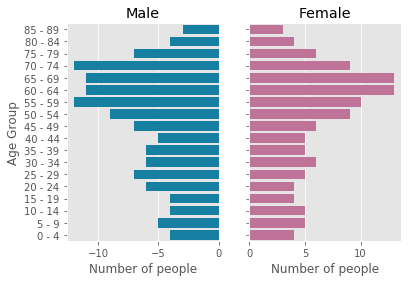

In [20]:
impacted_people = enrich(sdf, 'Age')
age_gender_pyramid(impacted_people);

# Conclusion

In this notebook example:
 - An image collection was created using the Sentinel-2 data, in order to perform fire analysis over the region of Spring Valley in Lake County, California, in the United States.
 - The pre and mid fire scenes were filtered out from the collection. 
 - Using the extract band function a visual assessment of the burnt area was carried out. 
 - The NBR on pre fire and mid fire scenes were computed and the NBR difference was calculated to identify places that had been affected by the fire. The values were normalized to match the burn severity index, color map raster function was applied to bring out the extent of the damage caused by fire and the burnt area was calculated. 
 - Finally, a human impact assessment was carried out by plotting the demographics of people affected by the fire, based on age and gender.

## Data Credits

Data available from the U.S. Geological Survey.
See [USGS Visual Identity System Guidance](https://www.usgs.gov/information-policies-and-instructions/copyrights-and-credits) for further details.
Questions concerning the use or redistribution of USGS data should be directed to:
ask@usgs.gov (link sends e-mail) or 1-888-ASK-USGS (1-888-275-8747).
